## Donwload essential libraries, uncomment to download if you need!

In [1]:
# !pip install torch
# !pip install qiskit
# !pip install qiskit_aer

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

## Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit_aer import Aer
from qiskit.visualization import *

## Define Quantum Circuit class with 1 hidden layer containing RY(theta)

In [3]:
class QuantumCircuit:
  def __init__(self, n_qubits, backend, shots):
    self._circuit = qiskit.QuantumCircuit(n_qubits)

    all_qubits = [i for i in range(n_qubits)]
    self.theta = qiskit.circuit.Parameter('theta')

    self._circuit.h(all_qubits)
    self._circuit.barrier()
    self._circuit.ry(self.theta, all_qubits)
    self._circuit.barrier()

    self._circuit.measure_all()

    self.backend = backend
    self.shots = shots

  def run(self, thetas):
    t_qc = transpile(self._circuit, self.backend)

    qobj = assemble(t_qc,
                    shots = self.shots,
                    parameter_binds = [{self.theta: theta} for theta in thetas])
    job = self.backend.run(qobj)
    result = job.result().get_counts()

    counts = np.array(list(result.values()))
    states = np.array(list(result.keys())).astype(float)

    probabilities = counts / self.shots
    expectation = np.sum(states * probabilities)

    return np.array([expectation])

## Test hidden layer with theta = np.pi

In [4]:
# View quantum circuit and prepare
simulator = Aer.get_backend('aer_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

Expected value for rotation pi 0.56


<ipython-input-3-c135c308a897>:24: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


┌───┐ ░ ┌───────────┐ ░  ░ ┌─┐
     q: ┤ H ├─░─┤ Ry(theta) ├─░──░─┤M├
        └───┘ ░ └───────────┘ ░  ░ └╥┘
meas: 1/════════════════════════════╩═
                                    0

In [5]:
class HybridFunction(Function):
  """Hybrid quantum - classical function definition"""

  @staticmethod
  def forward(ctx, input, quantum_circuit, shift):
    ctx.shift = shift
    ctx.quantum_circuit = quantum_circuit

    expectation_z = ctx.quantum_circuit.run(input[0].tolist())
    result = torch.tensor([expectation_z])
    ctx.save_for_backward(input, result)

    return result

  @staticmethod
  def backward(ctx, grad_output):
    input, expetation_z = ctx.saved_tensors
    input_list = np.array(input.tolist())

    shift_right = input_list + np.ones(input_list.shape) * ctx.shift
    shift_left = input_list - np.ones(input_list.shape) * ctx.shift

    gradients = []
    for i in range(len(input_list)):
      expectation_right = ctx.quantum_circuit.run(shift_right[i])
      expectation_left = ctx.quantum_circuit.run(shift_left[i])

      gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
      gradients.append(gradient)

    gradients = np.array([gradients]).T
    return torch.tensor([gradients]).float() * grad_output.float(), None, None


class Hybrid(nn.Module):
  """ Hybrid quantum - classical layer definition """

  def __init__(self, backend, shots, shift):
    super(Hybrid, self).__init__()
    self.quantum_circuit = QuantumCircuit(1, backend, shots)
    self.shift = shift

  def forward(self, input):
    return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [6]:
n_samples = 100
X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Label only digit 0 and 1
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples],
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 52138502.63it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2006454.77it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 6910314.77it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8565885.24it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



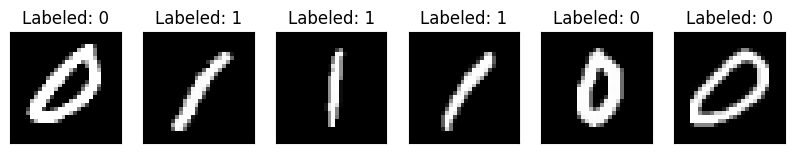

In [7]:
n_samples_show = 6
data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
  images, targets = data_iter.__next__()

  axes[n_samples_show-1].imshow(images[0].numpy().squeeze(), cmap='gray')
  axes[n_samples_show-1].set_xticks([])
  axes[n_samples_show-1].set_yticks([])
  axes[n_samples_show-1].set_title("Labeled: {}".format(targets.item()))
  n_samples_show -= 1


In [8]:
n_samples = 50
X_test = datasets.MNIST(root='./data', train=False, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Label only digit 0 and 1
idx = np.append(np.where(X_test.targets == 0)[0][:n_samples],
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

# Create Neural Network with 2 Convolutional, 2 Dense and a Quantum Layer

In [9]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.dropout = nn.Dropout2d()
    self.fc1 = nn.Linear(256, 64)
    self.fc2 = nn.Linear(64, 1)
    self.hybrid = Hybrid(Aer.get_backend('aer_simulator'), 100, np.pi/2)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2)
    x = self.dropout(x)
    x = x.view(1, -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = self.hybrid(x)
    return torch.cat((x, 1-x), -1)

# Train with 20 epoch

In [10]:
# Train neural network
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
  total_loss = []
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    # forward pass
    output = model(data)
    # calculate loss
    loss = loss_func(output, target)
    # backward pass
    loss.backward()
    # optimize weight
    optimizer.step()

    total_loss.append(loss.item())
  loss_list.append(sum(total_loss) / len(total_loss))
  print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
      100. * (epoch+1) / epochs, loss_list[-1]
  ))

<ipython-input-3-c135c308a897>:24: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)
<ipython-input-5-c826e5bfb239>:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  result = torch.tensor([expectation_z])


Training [5%]	Loss: -0.8126
Training [10%]	Loss: -0.9181
Training [15%]	Loss: -0.9407
Training [20%]	Loss: -0.9456
Training [25%]	Loss: -0.9553
Training [30%]	Loss: -0.9398
Training [35%]	Loss: -0.9640
Training [40%]	Loss: -0.9614
Training [45%]	Loss: -0.9661
Training [50%]	Loss: -0.9712
Training [55%]	Loss: -0.9706
Training [60%]	Loss: -0.9792
Training [65%]	Loss: -0.9814
Training [70%]	Loss: -0.9773
Training [75%]	Loss: -0.9824
Training [80%]	Loss: -0.9845
Training [85%]	Loss: -0.9830
Training [90%]	Loss: -0.9916
Training [95%]	Loss: -0.9879
Training [100%]	Loss: -0.9891


In [11]:
model.eval()

with torch.no_grad():
  correct = 0

  for batch_idx, (data, target) in enumerate(test_loader):
    output = model(data)

    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()

    loss = loss_func(output, target)
    total_loss.append(loss.item())

  print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
      sum(total_loss) / len(total_loss),
      correct / len(test_loader) * 100
  ))

<ipython-input-3-c135c308a897>:24: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Performance on test data:
	Loss: -0.9808
	Accuracy: 100.0%


<ipython-input-3-c135c308a897>:24: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


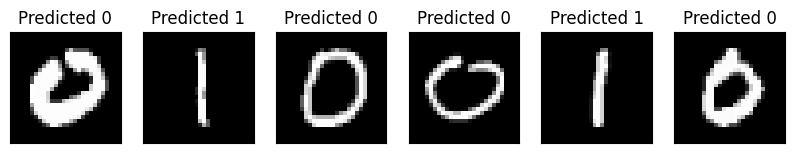

In [12]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
  for batch_idx, (data, target) in enumerate(test_loader):
    if count == n_samples_show: break

    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)
    axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

    axes[count].set_xticks([])
    axes[count].set_yticks([])
    axes[count].set_title('Predicted {}'.format(pred.item()))

    count += 1